# CoCoScore Implementation

This notebook consists of implementing the [CoCoScore](https://www.biorxiv.org/content/10.1101/444398v1) literature model for comparison. We report performance as area under the precision recall curve (AUPR) and area under the receiver operating curve (AUROC). In both cases the greater the area the better the model is.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import sys

sys.path.append(os.path.abspath('../../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, accuracy_score, confusion_matrix
from tqdm import tqdm_notebook

In [2]:
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes

In [3]:
total_candidates_df = pd.read_csv("input/all_dag_candidates.tsv.xz", sep="\t")
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,candidate_id,sentence_id,text,sen_length
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.8586,1,176680,2129459,The number of H antigen sites per single red c...,159
1,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.8586,1,176670,2129459,The number of H antigen sites per single red c...,159


In [4]:
spreadsheet_names = {
    'train': '../../data/sentences/sentence_labels_train.xlsx',
    'dev': '../../data/sentences/sentence_labels_dev.xlsx',
    'test': '../../data/sentences/sentence_labels_test.xlsx'
}

In [5]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_dsh")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of train set: 300
Size of dev set: 1000
Size of test set: 1000


In [6]:
distant_supervision_marginals = pd.read_csv("input/baseline_sampled.tsv.xz", sep="\t")
distant_supervision_marginals.head(2)

,"0:0,1,2,3,4,5,6",candidate_id
0,0.063069,21422
1,0.998302,21427


In [7]:
all_embedded_dg_df = pd.read_csv("input/all_embedded_dg_sentences.tsv.xz", sep="\t")
all_embedded_dg_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,candidate_id,sen_length
0,30,2451,3,8,2552,1130,8,564,3.0,3873.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21421,43
1,8,3102,3,4,277,6,1364,202,203.0,8057.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21422,18


In [8]:
word_dict = pd.read_csv("input/disease_associates_gene_word_dict.tsv", sep="\t").assign(index=lambda x: x.index + 2)
word_dict.head()

,word,index
0,overexpression,2
1,of,3
2,~~[[2,4
3,shp1,5
4,2]]~~,6


In [11]:
reverse_word_dict = dict(zip(word_dict['index'].values.tolist(), word_dict.word))

train_marginal_dict = dict(zip(
    distant_supervision_marginals.candidate_id, 
    distant_supervision_marginals[distant_supervision_marginals.columns[0]]
))

tune_marginal_dict = dict(zip(
    candidate_dfs['dev'].candidate_id.values,
    candidate_dfs['dev'].curated_dsh.values
))


test_marginal_dict = dict(zip(
    candidate_dfs['test'].candidate_id.values,
    candidate_dfs['test'].curated_dsh.values
))

In [12]:
data_rows = []
entity_one_start = word_dict.query("word=='~~[[1'")['index'].values[0]
entity_one_end = word_dict.query("word=='1]]~~'")['index'].values[0]

entity_two_start = word_dict.query("word=='~~[[2'")['index'].values[0]
entity_two_end = word_dict.query("word=='2]]~~'")['index'].values[0]

with open("output/optimization_data/training.txt", "w") as train:
    with open("output/optimization_data/tune.txt", "w") as tune:
        with open("output/optimization_data/test.txt", "w") as test:
            with open("output/all_dg_sentences.txt", "w") as all_sen:
                for idx, sen_df in tqdm_notebook(all_embedded_dg_df.iterrows()):
                    sen = sen_df.iloc[:-2].tolist()
                    try:
                        # remove entity mentions for coco_score
                        del sen[sen.index(entity_one_start): sen.index(entity_one_end)+1]
                        del sen[sen.index(entity_two_start): sen.index(entity_two_end)+1]

                        embedded_sen = list(map(
                            lambda x: reverse_word_dict[x] if x in reverse_word_dict else "UNK" if x == 1 else "",
                            sen
                        ))

                        cand_id = int(sen_df.iloc[-2])
                        if cand_id in train_marginal_dict:
                            train.write(
                                f"__label__{'1' if train_marginal_dict[cand_id]> 0.5 else '0'}\t" +
                                "\t".join(embedded_sen)+ 
                                "\n"
                            )
                        if cand_id in tune_marginal_dict:
                            tune.write(
                                f"__label__{int(tune_marginal_dict[cand_id])}\t" +
                                "\t".join(embedded_sen)+ 
                                "\n"
                            )
                        if cand_id in test_marginal_dict:
                            test.write(
                                f"__label__{int(test_marginal_dict[cand_id])}\t" +
                                "\t".join(embedded_sen)+ 
                                "\n"
                            )

                        all_sen.write(
                                f"__label__{cand_id}\t" +
                                "\t".join(embedded_sen) + 
                                "\n"
                            )

                    except ValueError:
                        print(idx)


/home/danich1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


3129733
3213766
3228428
3286544
3321817
3440104
3474638
3579193
3680330
3698151
3701848



In [13]:
os.system(
    "../../../../../fastText/fasttext supervised " + 
    "-input output/optimization_data/training.txt -output output/dag_model " +
    "-lr 0.005 -epoch 50 -dim 300 -wordNgrams 2" 
)

os.system(
    "../../../../../fastText/fasttext predict-prob "+
    "output/dag_model.bin output/optimization_data/tune.txt "+
    " > output/optimized_predictions/tune_predictions.tsv"
)

os.system(
    "../../../../../fastText/fasttext predict-prob "+
    "output/dag_model.bin output/optimization_data/test.txt "+
    " > output/optimized_predictions/test_predictions.tsv"
)

0

In [14]:
tune_df = (
    pd.read_csv(
        'output/optimized_predictions/tune_predictions.tsv', 
        header=None, sep=" ", 
        names=["label", "pred"]
    )
    .assign(label=lambda x: x.label.apply(lambda sen: sen[-1]))
)

precision, recall, _ = precision_recall_curve(
    tune_df.label.astype(int).values,
    1-tune_df.pred.values
)
auc(recall, precision)

0.5138218447856373

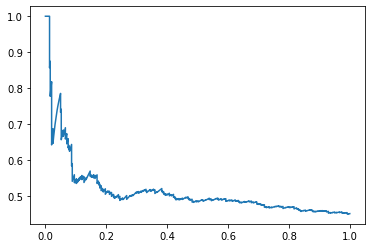

In [15]:
plt.plot(recall, precision)

In [16]:
fpr, tpr, _ = roc_curve(
    tune_df.label.astype(int).values,
    1-tune_df.pred.values
)
auc(fpr, tpr)

0.5561735377911848

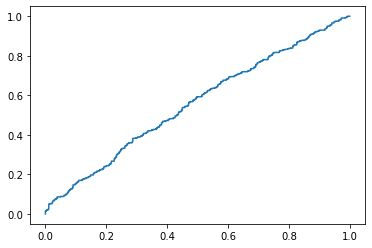

In [17]:
plt.plot(fpr, tpr)

In [18]:
os.system(
    "../../../../../fastText/fasttext predict-prob "+
    "output/dag_model.bin output/all_dg_sentences.txt "+
    "> output/all_dg_sentences_predictions.tsv"
)

0

In [21]:
predictions_df = (
    pd.read_csv(
        "output/all_dg_sentences_predictions.tsv", 
        header=None, sep=" ",
        names=["label", "coco_pred"]
    )
    .assign(
        candidate_id=(
            all_embedded_dg_df
            .drop([
                3129733,3213766,3228428,3286544,
                3321817,3440104,3474638,3579193,
                3680330,3698151,3701848]
            )
            .candidate_id
            .values
            .tolist()
        )
    )
    .assign(coco_pred=lambda x: 1 - x.coco_pred)
    .assign(coco_pred=lambda x: x.coco_pred.clip(0,1) + 1e-5)
)
predictions_df.head(2)

,label,coco_pred,candidate_id
0,__label__0,0.442621,21421
1,__label__0,0.046653,21422


In [22]:
final_pred_df = (
    total_candidates_df
    [["doid_id", "entrez_gene_id", "candidate_id"]]
    .merge(predictions_df[["coco_pred", "candidate_id"]])
)
final_pred_df.head(2)

,doid_id,entrez_gene_id,candidate_id,coco_pred
0,DOID:2531,1,1843691,0.459594
1,DOID:2531,1,2106410,0.256847


In [23]:
added_scores_df = (
    final_pred_df
    .groupby(["doid_id", "entrez_gene_id"])
    .aggregate({"coco_pred": 'sum'})
    .reset_index()
)
added_scores_df.head(2)

,doid_id,entrez_gene_id,coco_pred
0,DOID:0050156,2,0.096369
1,DOID:0050156,16,1.103194


In [26]:
total_score = added_scores_df.coco_pred.sum()
disease_scores = added_scores_df.groupby("doid_id").agg({"coco_pred":"sum"}).reset_index()
disease_scores = dict(zip(disease_scores.doid_id, disease_scores.coco_pred))
gene_scores = added_scores_df.groupby("entrez_gene_id").agg({"coco_pred":"sum"}).reset_index()
gene_scores = dict(zip(gene_scores.entrez_gene_id, gene_scores.coco_pred))

alpha=0.65

final_scores_df = added_scores_df.assign(
    final_score=(
        added_scores_df.apply(
            lambda x: pd.np.exp(
                    alpha*pd.np.log(x['coco_pred']) + (1-alpha)*(
                    pd.np.log(x['coco_pred']) + pd.np.log(total_score) - 
                    pd.np.log(disease_scores[x['doid_id']]) - pd.np.log(gene_scores[x['entrez_gene_id']])
                )
            ), 
            axis=1
        )
    )
)
final_scores_df.head(2)

,doid_id,entrez_gene_id,coco_pred,final_score
0,DOID:0050156,2,0.096369,0.112354
1,DOID:0050156,16,1.103194,8.867530


In [27]:
score_with_labels_df = (
    final_scores_df
    .merge(
        total_candidates_df[["entrez_gene_id", "doid_id", "hetionet"]],
        on=["entrez_gene_id", "doid_id"]
    )
    .drop_duplicates()
)
score_with_labels_df.head(2)

,doid_id,entrez_gene_id,coco_pred,final_score,hetionet
0,DOID:0050156,2,0.096369,0.112354,0
2,DOID:0050156,16,1.103194,8.867530,0


In [28]:
(
    score_with_labels_df
    .drop("coco_pred", axis=1)
    .rename({"final_score": "coco_score"})
    .to_csv("output/dg_edge_prediction_cocoscore.tsv", sep="\t", index=False)
)

In [29]:
fpr, tpr, _ = roc_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(fpr, tpr))

precision, recall, _ = precision_recall_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(recall, precision))

0.825075467995092
0.4414667737189867
